# Example 1c: Relative amplitude measurement

In this example we measure relative amplitudes on the aligned waveforms from the previous example. They provide the measurements we need to compute relative earthquake moment tensors. Amplitudes are measured in a specific frequency band, where we need to filter event combenations below the corner frequency of the largest event. *relMT* implements various algorithms to achieve this.

This notebook relies on the data previously created in the Example 1b.

Let us first change into the working directory...

In [1]:
%cd muji

/projects/restricted/relMT/relmt/src/relMT/examples/muji


... and import the modules required for this example.

In [2]:
from relmt import io
from IPython.display import Image, display # trick to show files in notebook

## Setting up a working configuration file
Let us set some [configuration values](https://relmt.readthedocs.io/en/latest/formats/file_formats.html#configuration-file-config-yaml) that proved useful for this example.

The following configuration instructs `relmt amplitude` to do the following:

* Append the suffix "auto" to all files created
* Find automatic filter passbands for each event.
* Find the event lowpass frequency as the maximum in the velocity spectrum (the apparent corner frequency).
* Search for the maximum in the velocity spectrum inside the frequency band implied by a stressdrop range between 0.1 and 10 MPa.
* Respecting the lowpass frequency, only include the frequency band with a signal-to-noise ratio > 0 dB.
* Measure relative amplitude 'directly', on the seismograms, between event combinations (pairs for *P*-waves, tripplets for *S*-waves).
* Only allow event combinations with a common optimal bandpass with a dynamic range of at least 1dB.

In practice, we would open an editor and manipulate `config.yaml` accordingly.

In [3]:
config = io.read_config("config.yaml")

# Suffix appended to files, naming the parameters parsed to 'amplitude'
# (str)
config["amplitude_suffix"] = "auto"

# Filter method to apply for amplitude measure. One of:
#    - 'manual': Use 'highpass' and 'lowpass' of the waveform header files.
#    - 'auto': compute filter corners using the "auto" options below
# (str)
config["amplitude_filter"] = "auto"

# Method to estimate lowpass filter that eliminates the source time function. One
# of:
#    - 'corner': Estimate from apparent corner frequency in event spectrum.
#      Requires 'auto_lowpass_stressdrop_range'
#    - 'duration': Filter by 1/source duration of event magnitude. 
# (str)
config["auto_lowpass_method"] = "corner"

# When estimating the lowpass frequency of an event as the corner frequency
# (auto_lowpass_method: 'corner'), assume a stressdrop within this range (Pa).
# When second value is less or equal first value, use a fixed stressdrop of first
# value.
# ([float, float])
config["auto_lowpass_stressdrop_range"] = [1e5, 1e7]

# Include frequencies with this signal-to-noise ratio to optimal bandpass filter.
# Respects lowpass constraint. If not supplied, do not attempt to optimize
# passband.
# (float)
config["auto_bandpass_snr_target"] = 0

# Method to meassure relative amplitudes. One of:
#    - 'indirect': Estimate relative amplitude as the ratio of principal seismogram
#      contributions to each seismogram.
#    - 'direct': Compare each event combination seperatly.
# (str)
config["amplitude_measure"] = "direct"

# Minimum ratio (dB) of low- / highpass filter bandwidth in an amplitude ratio
# measurement. When positive, discard observation outside dynamic range. When
# negative, lower the highpass until the (positive) dynamic range is reached.
# (float)
config["min_dynamic_range"] = 1.0

config.to_file("config.yaml", overwrite=True)

INFO    : Configuration written to: config.yaml


## Compute filter bands and relative amplitudes
We run `relmt amplitude` on the command line. To indicate that we would like to measure amplitdues on the waveforms stored in the `align2/` directory, we parse the `-a 2` flag. Computation of the filter bands and amplitudes takes a couple of (possibly 10) minutes.

In [4]:
! relmt amplitude -a 2

INFO    : Finding filter automatically
INFO    : Reading bandpass from file: amplitude/bandpass-auto.yaml
INFO    : Collecting observations. This may take a while...
INFO    : Collected 20029 P- and 1133918 S-combinations
INFO    : Computing relative P-amplitudes...
INFO    : Computing relative S-amplitudes...


## Admit amplitudes into the linear system of equations

We found relative amplitudes for 21,889 *P*-wave paris and 963,140 *S*-wave triplets. We next admit the equations that should go into the linear system. The following configuration admits:

* relative *P* amplitudes with a misfit better than 0.9
* relative *S* amplitudes with a misfit better than 0.7
* relative *S* amplitudes with a sigma1 value lower than 0.99
* events that are constrained by at least 10 equations
* events that have a azimuthal gap lower than 270 degree
* both equations of each *S* observation triplet (representing the two polarization vectors)
* of the remaining *S*-equations, the 15000 least redundant ones, re-iterating 100 times.

After setting these values, we write the configuration to file and call `relmt admit` to write a new amplitude file, which now carries the suffix `-admit`. The next step also takes a few (possibly 2) minutes.

In [5]:
# Suffix appended to the amplitude suffix, naming the quality control parameters
# parsed to 'relmt admit'
# (str)
config["admit_suffix"] = "admitted"

# Discard amplitude measurements with a higher misfit than this. Applies only to P
# amplitudes if 'max_s_amplitude_misfit' is given.
# (float)
config["max_amplitude_misfit"] = 0.9

# If given, discard S amplitude measurements with a higher misfit.
# 'max_amp_misfit' then only applies to P amplitudes.
# (float)
config["max_s_amplitude_misfit"] = 0.7

# Maximum first normalized singular value to allow for an S-wave reconstruction. A
# value of 1 indicates that S-waveform adheres to rank 1 rather than rank 2 model.
# The relative amplitudes Babc and Bacb are then not linearly independent.
# (float)
config["max_s_sigma1"] = 0.99

# Minimum number of equations required to constrain one moment tensor
# (int)
config["min_equations"] = 10

# Maximum azimuthal gap allowed for one moment tensor
# (float)
config["max_gap"] = 270

# Use two equations per S-amplitude observation (`False` only includes the one
# with the highest norm of the polarization vector).
# (bool)
config["two_s_equations"] = True

# Maximum number of S-wave equation in the linear system. If more are available,
# iterativley discard those with redundant pair-wise observations, on stations
# with many observations, and with a higher misfit
# (int)
config["max_s_equations"] = 15000

# When reducing the number of S-wave equations, rank observations iteratively this
# many times by redundancy and remove the most redundant ones. A lower number is
# faster, but may result in discarding less-redundant observations.
# (int)
config["equation_batches"] = 100

# Save it to file
config.to_file("config.yaml", overwrite=True)

! relmt admit

INFO    : Configuration written to: config.yaml
INFO    : Excluded 0 P-observations because stations or waveforms are excluded
INFO    : Excluded 0 more P-observations from exclude file
INFO    : Excluded 0 more P-observations due bad amplitude
INFO    : Excluded 13266 more P-observations due to high misfit
INFO    : Excluded 0 more P-observations due high sigma1
INFO    : Excluded 0 S-observations because stations or waveforms are excluded
INFO    : Excluded 0 more S-observations from exclude file
INFO    : Excluded 0 more S-observations due bad amplitude
INFO    : Excluded 781393 more S-observations due to high misfit
INFO    : Excluded 35019 more S-observations due high sigma1
INFO    : Have 587898 S-equations, need to reduce by 572898
INFO    : Selected 6700 P equations
INFO    : Selected 15000 S equations


### Check the results
Each line in the newly created *P* amplitude file corresponds to one equation in the linear system, and each line in the *S* amplitude file to two (because `two_s_equations` is `True`). Each file has one header line.

In [6]:
! wc -l amplitude/[PS]-amplitudes*.txt

     6701 amplitude/P-amplitudes-auto-admitted.txt
    20030 amplitude/P-amplitudes-auto.txt
     7501 amplitude/S-amplitudes-auto-admitted.txt


  1133919 amplitude/S-amplitudes-auto.txt
  1168151 total


## Solve the linear system
We now read the file with the admitted amplitudes and build a linear system of equations according to the following configuration:

* Append the suffix "7508" to the result files, indicating the number of the used reference event.
* Use event *7508* (the M 4.2) as the refence event.
* Weight the reference event with a weight of 1000
* Apply a deviatoric constraint to the solution (solve for 5 MT elements)
* Apply the maximum weight of *1* to amplitude measurements with a misfit at or below *0.05*
* Weight the worst accepted misfit *0.1*
* Draw *100* bootstrap samples to detect unstable solutions

In [7]:
# Solve parameters
# ----------------
# 
# Suffix appended to amplitude and admit suffices indicating the parameter set parsed
# to 'solve'
# (str)
config["result_suffix"] = "7508"

# Event indices of the reference moment tensor(s) to use
# (list)
config["reference_mts"] = [7508]

# Weight of the reference moment tensor
# (float)
config["reference_weight"] = 1000

# Constrain the moment tensor. 'none' or 'deviatoric'
# (str)
config["mt_constraint"] = "deviatoric"

# Minimum misfit to assign a full weight of 1. Weights are scaled lineraly from
# `min_amplitude mistfit` = 1 to `max_amplitude_misfit` = `min_amplitude_weight`
# (float)
config["min_amplitude_misfit"] = 0.05

# Lowest weight assigned to the maximum amplitude misfit
# (float)
config["min_amplitude_weight"] = 0.1

# Number of samples to draw for calculating uncertainties. If not given, do not
# bootstrap.
# (int)
config["bootstrap_samples"] = 100

config.to_file("config.yaml", overwrite=True)

INFO    : Configuration written to: config.yaml


...build and solve the linear system...

In [8]:
! relmt solve

INFO    : Building linear system of 6700 P, 15000 S, and 1 reference equations.
INFO    : Computing norms and weights...
INFO    : Solving linear system of 735 variables and 21705 equations...
INFO    : Running lsmr...
INFO    : lsmr ended after 168 iterations with exit code 2
INFO    : Computing 100 bootstrap samples...
INFO    : Saving full summary to: result/mt_summary-auto-admitted-7508.txt


... and have a look at the result

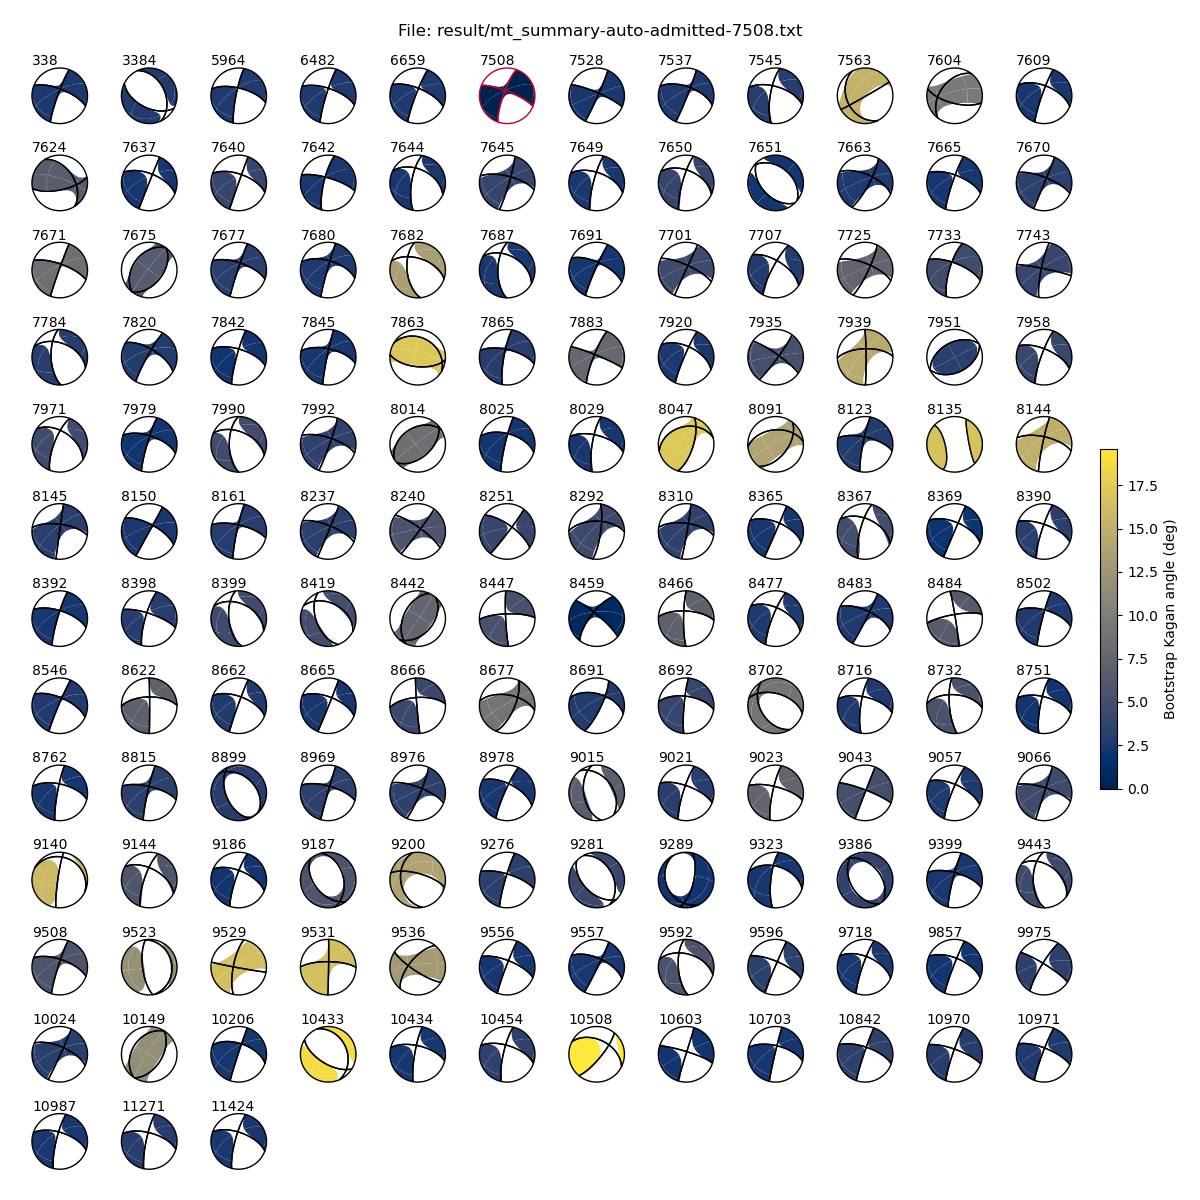

In [9]:
! relmt plot-mt --sort-by name --highlight 7508 --color-by boot-kagan --dc 0.2 --saveas ref7508.png result/mt_summary-auto-admitted-7508.txt
display(Image("ref7508.png"))

### Try a different reference MT
We have another reference event available, event *7640* (M 5.0). Let us try and see how the results change when we use it as a reference. We change the configuration file by setting a new `reference_mts` list and append a changed `result_suffix` to the resulting files.

In [10]:
config["result_suffix"] = "7640"
config["reference_mts"] = [7640]
config.to_file("config.yaml", True)

! relmt solve

INFO    : Configuration written to: config.yaml
INFO    : Building linear system of 6700 P, 15000 S, and 1 reference equations.
INFO    : Computing norms and weights...
INFO    : Solving linear system of 735 variables and 21705 equations...
INFO    : Running lsmr...
INFO    : lsmr ended after 199 iterations with exit code 2
INFO    : Computing 100 bootstrap samples...
INFO    : Saving full summary to: result/mt_summary-auto-admitted-7640.txt


... and, have a look at the results...

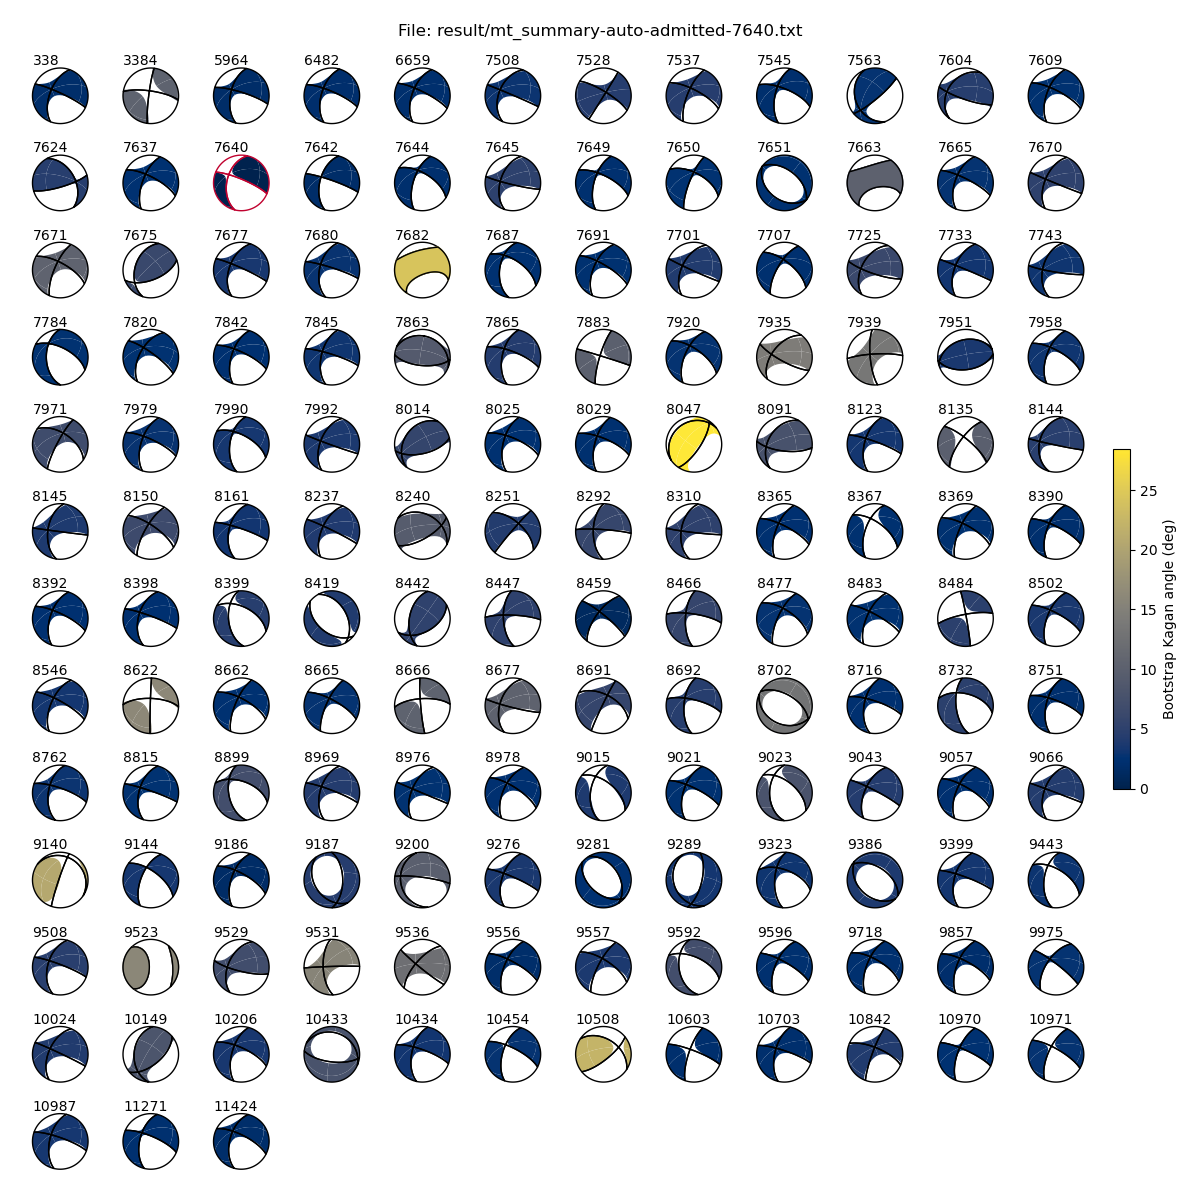

In [11]:
! relmt plot-mt --sort-by name --highlight 7640 --color-by boot-kagan --dc 0.2 --saveas ref7640.png result/mt_summary-auto-admitted-7640.txt
display(Image("ref7640.png"))

## Conclusion
In this notebook, we read aligned waveforms, determined optimal filter parameter, measured relative amplitudes, and computed relative moment tenors for two different reference moment tensors. In the next notebook we will have a look at how to interpret the results.